<a href="https://colab.research.google.com/github/kelly2110/PRA3024-Analysis-of-Big-Data-in-Physics/blob/main/PRA3024_Gravitational_Waves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GENERAL SETUP**

In [1]:
# Fetching the data from LIGO --> I directly downloaded the data from the file further down below!
#!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
#!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf 

In [2]:
# Installing pycbc
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Importing packages
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np

# **EXERCISE 1 Matched Filter**





**Part 1**

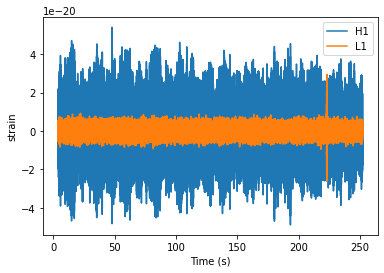

In [4]:
# Loading the data and plotting the signal over a timeSeries

d = np.load('/content/drive/MyDrive/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to convert data into GW timeSeries
#merger = Merger("GW170817") 
strain, stilde = {}, {}

# Downsampling to 2048 Hz and removing low frequency content:
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048) # H stands for Hanford
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048) #L stands for Livingston


# Removing the begining and ending spikes from the data/time corrupted by the high pass filter
strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

# Creating a frequency domain version of the data:
stilde['H1'] = strain['H1'].to_frequencyseries() 
stilde['L1'] = strain['L1'].to_frequencyseries()
 
# Plotting the data for both H1 and L1:
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


**Part 2**

The delta_f of the psds is:


0.004032258064516129

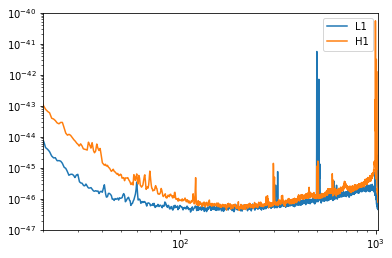

In [5]:
# Write down the code to calculate the matched filter between the given data and a template waveform.
# --> Need to first calculate power spectral density (psds)
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t) 
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo], 
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1028)
    pylab.ylim(1e-47, 1e-40)
pylab.legend()

print("The delta_f of the psds is:")
psds[ifo].delta_f

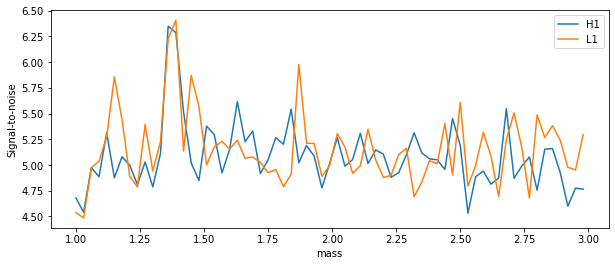

In [6]:
# Find out the template waveform for which the signal to noise ratio (SNR) is maximum.
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
import numpy as np
from numpy import arange

#mass2 = mass1 because it is an equal mass binary system

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
Snr_list = []
masses = arange(1,3,0.03) # given mass range bewteen 1 to 3 Solar mass, step size of 0.03

 # Looping over both H1 and L1 simultaneously:
for ifo in ['H1', 'L1']:
  for m in masses:

    # Generating a waveform 
    hp, hc = get_td_waveform(approximant="TaylorT2",
                            mass1=m,
                            mass2=m,
                            delta_t=strain[ifo].delta_t,
                            f_lower=20)
    #Resizing the vector to match the data
    hp.resize(len(strain[ifo]))
    # Creating a template from the generated waveform 
    template = hp.cyclic_time_shift(hp.start_time)
    # Estimating the SNR between the template and the data
    snr = matched_filter(template, strain[ifo],
                          psd=psds[ifo], 
                          low_frequency_cutoff=20)
    
    # Remove time corrupted by the template filter and the psd filter
    snr1 = snr.crop(4 + 4, 4)


    snrs[ifo] = Snr_list.append(max(abs(snr1)))
  snrs[ifo] = Snr_list
  Snr_list = []


# Plotting the SNR for both H1 and L1 against the mass range
pylab.figure(figsize=[10, 4])
pylab.plot(masses, snrs['H1'], label = 'H1')
pylab.plot(masses, snrs['L1'], label = 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

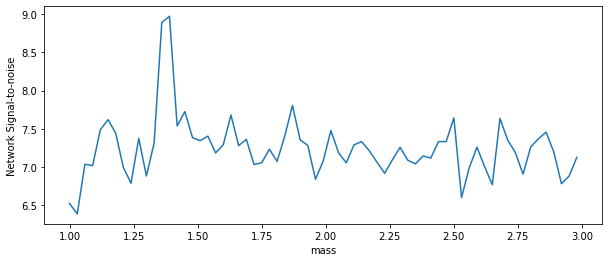

We found the best Mass1=Mass2 was 1.39 solar masses (detector frame)


In [8]:
# Combining the SNRs from L1 and H1 in one plot, which will give the optimal mass
import numpy as np
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5 # nsnr = network snr
ii = np.where(nsnr == max(nsnr)) #for which mass does nsnr become maximum?
pylab.figure(figsize=[10, 4])
pylab.plot(masses, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % masses[ii])

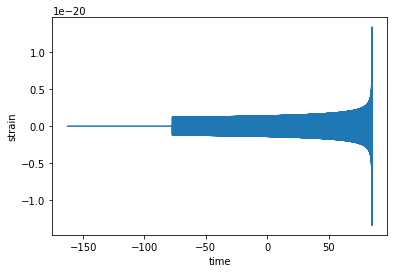

In [9]:
# Creating + plotting the template waveform
m = 1.39 # Solar masses
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# we need to shift the data so that the merger is approximately at the # first bin of the data.
# This function rotates the vector by a fixed amount of time.
# We can use the start time to shift the merger into position.
template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

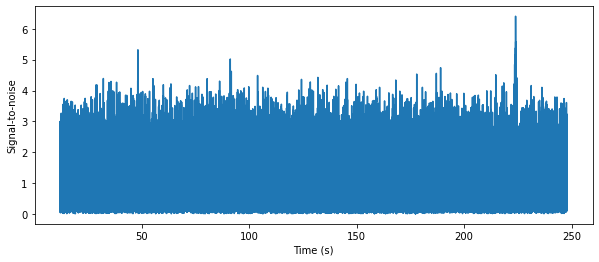

We found a signal at 223.9755859375s with SNR 6.406269877975566


In [11]:
# Actually calculating the matched filter between the template waveform and the data
from pycbc.filter import matched_filter


ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

From this we can conclude that there is indeed a signal present at 224 s with a SNR of 6.4





In [12]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

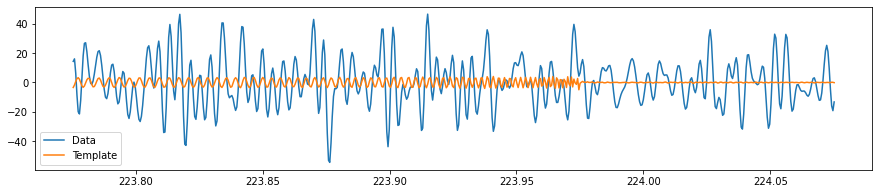

In [13]:
# Representing the result by fitting the best match template waveform against the data.

# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)

# Select the time around the merger --> we are not working with Merger so had to change this to snr.sample_times[peak]
white_data = white_data.time_slice(snr.sample_times[peak]-.2, snr.sample_times[peak]+.1)
white_template = white_template.time_slice(snr.sample_times[peak]-.2, snr.sample_times[peak]+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()



It can be seen that the template does not appear to fit the data as hoped for

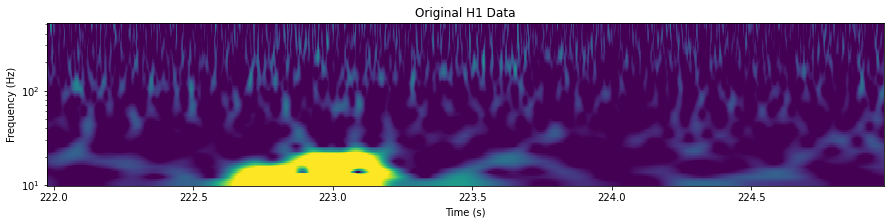

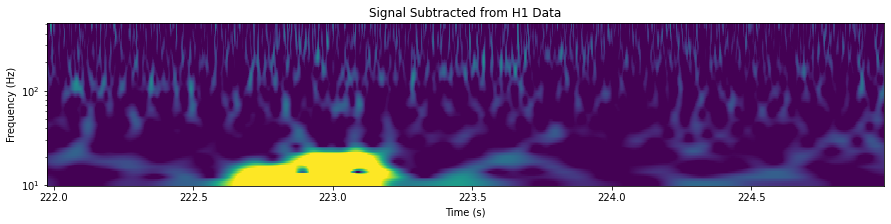

In [14]:
#Showing the chirp structure of the signal over the time-frequency domain using Q-transformation().
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(10, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(snr.sample_times[peak] - 2, snr.sample_times[peak] + 1)
    pylab.show()



As we can see, the "charge" does not disappear. This was to be expected as our template does not seem to match the data very well.

**Part 3**

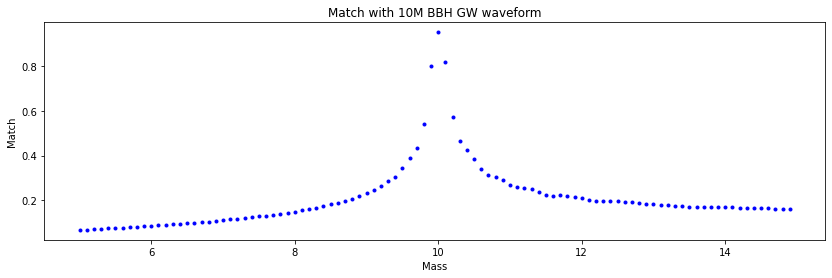

In [15]:
#  Calculate the match between h*(t;m1;m2) and the nearby templates
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import numpy
from numpy import arange

f_low = 30
sample_rate = 4096
masses = arange(5,15,0.1) #Mass range between 5-15, stepsize of 0.1
matches = {}

for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  # Note: This takes a while the first time as an FFT plan is generated
  # subsequent calls are much faster.
  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'b.')
pylab.show()


# **Exercise 2 Detector Noise**




In [16]:
# Loading data
import numpy as np
'''
Loading the data and converting the data type into time series
'''
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d

**Part 1**

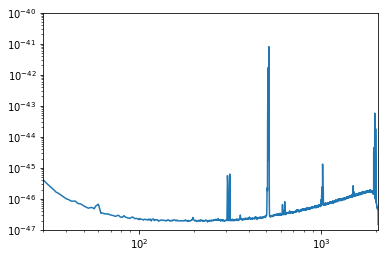

In [17]:
# Test whether there is any gravitational wave signal present in the data or not? 
# For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. 
# We assume a threshold on matched filter SNR of 8 to claim detection of GW.

# Plotting the PSD:
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)

pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(30, max(psd.sample_frequencies))
pylab.ylim(1e-47, 1e-40)
pylab.show()

No gravitational wave was detected


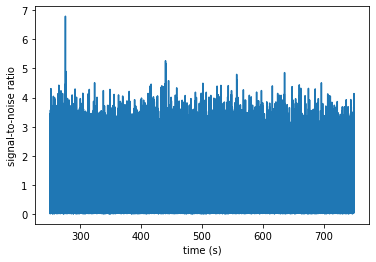

Max SNR: 6.7952767922375825


In [18]:
# Calculate the matched filter using template waveforms with mass ranges between 5 to 10. And see if your maximum SNR(signal to noise ratio) crosses 8.
# If not, this means you have only noise, no signal.
flow = 20 #Hz
stilde = data.to_frequencyseries()
masses = np.arange(5,10,0.1)
maxsnr = 0
snrp = 0
# Looping through the masses and creating a waveform for each mass
for i in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                               mass1=i, mass2=i,
                               f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde))  
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                       low_frequency_cutoff=flow)

# Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]


# Filter for the biggest SNR:
  if max(abs(snr)) > maxsnr:
    maxsnr = max(abs(snr))
    snrp = snr

#check if a gravitational wave is present
if maxsnr < 8:
  print ("No gravitational wave was detected")
else:
  print("A gravitational wave was detected!")

#Plot SNR over time
pylab.plot(snrp.sample_times, abs(snrp))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()
print("Max SNR: {}".format(maxsnr))

As the code says, the maximum SNR found was 6.8, which is below 8 and therefore indeed no gravitational wave was detected, meaning that the data is only noise

**Part 2**

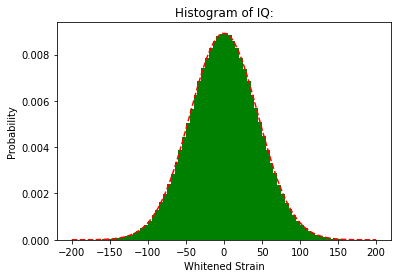

μ is equal to: 0.0014166022882674619
σ is equal to: 44.72975447257879


In [19]:
# Whiten the above data using its noise PSD
import pycbc.psd
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab

#Dividing data by PSD and cropping it
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)
     

#Plotting the whitened data 
plt.hist(white_data, range(-200,200,5), color = "green", density=True)
 
# Plotting Best Fit
(mu, sigma) = norm.fit(white_data) # mean and standard deviation

x = np.linspace(-200,200, 100)
plt.plot(x, norm.pdf(x, mu, sigma), linewidth = 1.5, color = "red", linestyle = "dashed")

plt.title(r'Histogram of IQ:')
plt.xlabel("Whitened Strain")
plt.ylabel("Probability")
plt.show() 
print("μ is equal to: {}".format(mu))
print("σ is equal to: {}".format(sigma))

It can be seen that the data indeed follows a Gaussian distribution with zero as a mean

**Part 3**

In [20]:
# Test to show that the stationary assumption does not hold
from pycbc.waveform import get_fd_waveform

# Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0) #Luminosity distance = 500 Mpc


                         

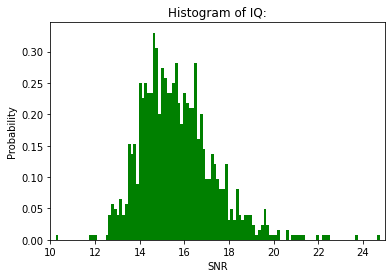

μ is equal to: 15.703778392202603
σ is equal to: 1.776715513512125


In [21]:
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

# Slicing the data 
data_slice = int(len(data)/1000)
snrlist = []

# Estimate the PSD for all slices
for i in range(0, 1000):

  data_chunk = data[i * data_slice: (i+1)*data_slice]
  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)
  snr = (pycbc.filter.sigmasq(hp, psds))**0.5
  snrlist.append(snr)

# Plotting histogram
(mu, sigma) = norm.fit(snrlist)
plt.title('Histogram of IQ:')
plt.xlabel("SNR")
plt.ylabel("Probability")
plt.hist(snrlist, 200, density = True, color = 'green')
plt.xlim(10,25)
plt.show()
print("μ is equal to: {}".format(mu))
print("σ is equal to: {}".format(sigma))

From the plot it can be concluded that we are dealing with a non-stationary Gaussian distribution, and thus the assumption was false

# **Exercise 3 Horizon Distance of Detectors**

**Part 1**

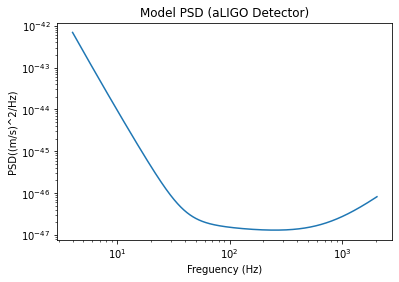

In [22]:
#Plot the horizon distance for Advanced LIGO detector (assuming ’H1’ noise PSD) assuming a set of equal mass
#binary with a range of component masses between 5 to 500. 
# In this plot, you can #assume that X-axis and Y-axis represent the total mass of the binary and horizon distance


#Calculate modeled PSD
import pycbc.psd
import numpy as np
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# Plot modeled PSD
pylab.loglog(psd.sample_frequencies, psd)
pylab.title("Model PSD (aLIGO Detector)")
pylab.xlabel("Freguency (Hz)")
pylab.ylabel("PSD((m/s)^2/Hz)")
pylab.show()
     


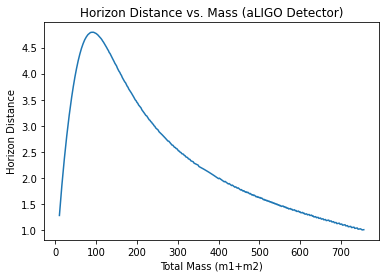

In [23]:
# Estimate horizon distance for aLIGO by estimating the distance at which the value of SNR will be 8.

# Generate a waveform and estimate the SNR
flow = 4.0 
masses = np.arange(5, 500, 1)
horizon_distance = []
total_mass = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
    mass1=m, mass2=m,
    f_lower=flow,
    delta_f=1.0 / 16,
    distance = 1000) #Mpc

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5

  if SNR > 8:
    horizon_distance.append(SNR/8)
    total_mass.append(m*2)

pylab.plot(total_mass, horizon_distance)
pylab.ylabel("Horizon Distance")
pylab.xlabel("Total Mass (m1+m2)")
pylab.title("Horizon Distance vs. Mass (aLIGO Detector)")
pylab.show()



**Part 2**
From the plot we can see that until a certain mass the horizontal distance increases, because the frequency of this binary system can still be picked up by the detector. But after a while the horizontal distance of the binary system decreases with increasing mass. This is because the frequency of the GW keeps increasing to a point where the detector cannot really pick up the frequency, and thus the signal anymore. The detector has an optimal frequency range for which it works best, and after that it slowly declines with mass.

The Einstein telescope is more sensitive than LIGO (as we can see below) and can therefore detect higher frequencies and thus also more merging events from bigger binary systems, which is why the horizon distance does not decline nearly as fast as for the LIGO Detector. It is also able to pick up lower frequencies than LIGO, as the plot for the ET has a less sharp peak than the one for LIGO. However in the end, the ET also has an optimal frequency range, after which it also declines with mass. 


**Part 3**

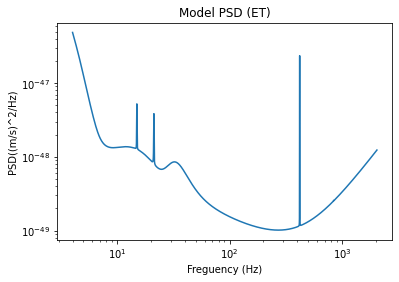

In [24]:
# Calculate modeled PSD
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.title("Model PSD (ET)")
pylab.xlabel("Freguency (Hz)")
pylab.ylabel("PSD((m/s)^2/Hz)")
pylab.show()
pylab.show()

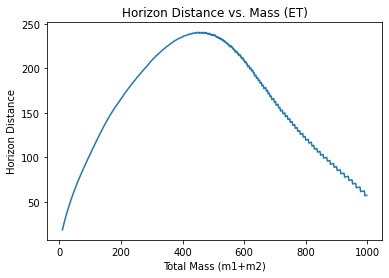

In [25]:
# estimate horizon distance for Einstein Telescope by estimating the distance at which the value of SNR will be 8.

flow = 4.0 
masses = np.arange(5, 500, 1)
horizon_distance = []
total_mass = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
    mass1=m, mass2=m,
    f_lower=flow,
    delta_f=1.0 / 16,
    distance = 1000)

  SNR = (pycbc.filter.sigmasq(hp, psd))**0.5

  if SNR > 8:
    horizon_distance.append(SNR/8)
    total_mass.append(m*2)

pylab.plot(total_mass, horizon_distance)
pylab.ylabel("Horizon Distance")
pylab.xlabel("Total Mass (m1+m2)")
pylab.title("Horizon Distance vs. Mass (ET)")
pylab.show()

**For comparison and conclusion see above**